# Capstone Project 2
Comparing Microsoft Stock Price Movement Prediction With LSTM & FB Prophet

## Data Wrangling
### Import packages for data wrangling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

### Define functions for data wrangling

In [2]:
def to_log_rtn(df, col='5. adjusted close', shift=1):
   
    """
    df is a pandas dataframe
    col is the name of the column corresponding to the price
    shift is the number of days for the return (5 = weekly, 20 = monthly, etc...) in business days
    """
    
    return np.log(df[col]/df[col].shift(shift))

In [3]:
def to_log_HL(df, high, low, shift=1):
    
    """
    df is a pandas dataframe
    high & low are the name of the columns corresponding to the daily high & low values
    shift is the number of days for the return (5 = weekly, 20 = monthly, etc...) in business days
    """
    
    return np.log(df[high].rolling(window=shift).max()/df[low].rolling(window=shift).min())  

In [4]:
def toTimeSeries(df, columns, trail, lead):
    """
    custom function to create supervised dataset with trailing & leading data
    """
    df = df[columns]
    n_columns = len(columns)
    cols = []
    names = []
    #create trail
    for i in range(trail, 0, -1):
        cols.append(df.shift(i))
        names += [(columns[j] + '(t - %d)' % (i)) for j in range(n_columns)]
    
    #create lead
    for i in range(0, lead+1):
        cols.append(df.shift(-i))
        names += [(columns[j] + '(t + %d)' % (i)) for j in range(n_columns)]
        
    #aggregate lead & trail
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    
    return agg

### Import Data

In [5]:
df = pd.read_csv('raw data/msft.csv')

### Convert data to lognormal distribution

In [6]:
daily_return = to_log_rtn(df, '5. adjusted close')

In [7]:
weekly_return = to_log_rtn(df, '5. adjusted close', 5)

In [8]:
monthly_return = to_log_rtn(df, '5. adjusted close', 20)

In [9]:
quarterly_return = to_log_rtn(df, '5. adjusted close', 60)

In [10]:
dailyHL = to_log_HL(df, '2. high', '3. low')

In [11]:
weeklyHL = to_log_HL(df, '2. high', '3. low', 5)

In [12]:
monthlyHL = to_log_HL(df, '2. high', '3. low', 20)

In [13]:
quarterlyHL = to_log_HL(df, '2. high', '3. low', 60)

### Create lognormalized data set

In [14]:
data = pd.concat([daily_return, weekly_return, monthly_return, quarterly_return,
                  dailyHL, weeklyHL, monthlyHL, quarterlyHL], axis=1)
data.columns = ['daily_return', 'weekly_return', 'monthly_return', 'quarterly_return', 
                'daliyHL', 'weeklyHL', 'monthlyHL', 'quarterlyHL']
data.dropna(inplace=True)

### Convert data to time series for LSTM

In [15]:
n_trail = 60  # 60 business days is 3 months
n_lead = 60
columns = ['daily_return', 'weekly_return', 'monthly_return', 'quarterly_return', 
           'daliyHL', 'weeklyHL', 'monthlyHL', 'quarterlyHL']
reframed = toTimeSeries(data, columns, n_trail, n_lead)

### Split data into testing & training sets

In [16]:
split = 0.75  # portion of data used for training

values = reframed.values

mask = np.random.rand(len(values)) < split

train = values[mask]
test = values[~mask]

### Define parameters of the data set

In [17]:
n_columns = len(columns)
n_features = (n_lead - 1) *  len(columns)
n_periods = n_trail + 1
n_obs = n_periods * n_columns

### Split testing & training sets into features and target

In [18]:
X_train, y_train = train[:, 0:n_obs], train[:, -n_features:]
X_test, y_test = test[:, 0:n_obs], test[:, -n_features:]

### Reshape data for use in LSTM model

In [19]:
X_train = X_train.reshape((X_train.shape[0], n_periods, n_columns))
X_test = X_test.reshape((X_test.shape[0], n_periods, n_columns))

In [20]:
new = []

for i, train in enumerate(y_train):
    new.append(y_train[i][-n_columns:].tolist())
    
y_train = np.array(new)

new = []

for i, test in enumerate(y_test):
    new.append(y_test[i][-n_columns:].tolist())
    
y_test = np.array(new)

## LSTM Model
### Import LSTM packages

In [26]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


### Define LSTM model

In [27]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1:])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(len(columns)))
model.compile(loss='mse', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.


### Train model

In [28]:
history = model.fit(X_train, y_train, epochs=50, batch_size=72,
                     validation_data=(X_test, y_test), shuffle=False)

Instructions for updating:
Use tf.cast instead.
Train on 1520 samples, validate on 563 samples
Epoch 1/50
1520/1520 [==============================] - 5s 3ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 2/50
1520/1520 [==============================] - 3s 2ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 3/50
1520/1520 [==============================] - 3s 2ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 4/50
1520/1520 [==============================] - 3s 2ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 5/50
1520/1520 [==============================] - 3s 2ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 6/50
1520/1520 [==============================] - 3s 2ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 7/50
1520/1520 [==============================] - 3s 2ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 8/50
1520/1520 [==============================] - 3s 2ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 9/50
1520/1520 [==============================] - 3s 2ms/step - loss: 0.0018 - val_

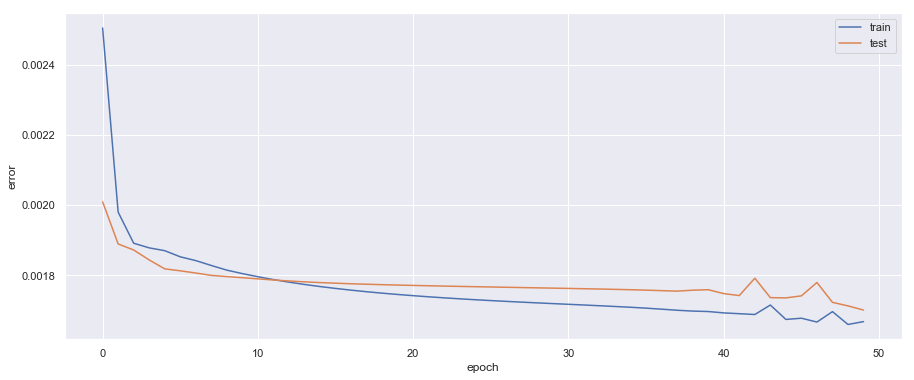

In [29]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

plt.ylabel('error')
plt.xlabel('epoch')
plt.show()

### Test model & analyze results

In [30]:
prd = model.predict(X_test)

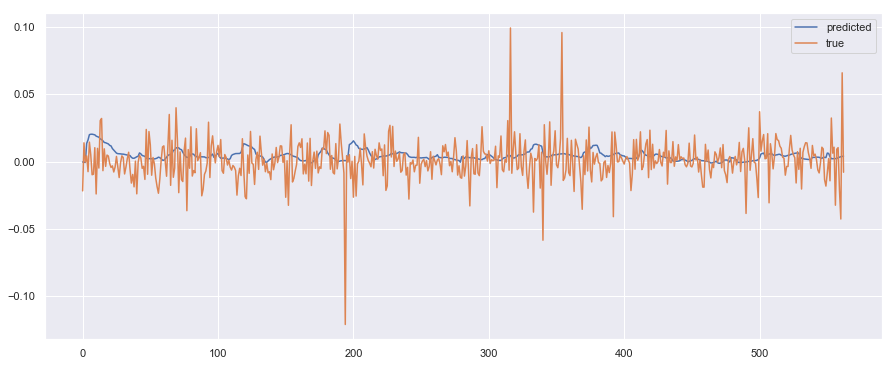

In [31]:
results = pd.DataFrame(prd)
results.columns = columns
real = pd.DataFrame(y_test, columns=columns)
real.columns += '_y_test'

results = pd.concat([results, real], axis=1)

plt.figure(figsize=(15,6))
plt.plot(results.daily_return, label='predicted')
plt.plot(results.daily_return_y_test, label='true')
plt.legend()
plt.show()

In [32]:
results['correct_daily_return_direction'] = (results.daily_return*results.daily_return_y_test).apply(lambda x: 1 if x > 0 else 0)
results['correct_weekly_return_direction'] = (results.weekly_return*results.weekly_return_y_test).apply(lambda x: 1 if x > 0 else 0)
results['correct_monthly_return_direction'] = (results.monthly_return*results.monthly_return_y_test).apply(lambda x: 1 if x > 0 else 0)
results['correct_quarterly_return_direction'] = (results.quarterly_return*results.quarterly_return_y_test).apply(lambda x: 1 if x > 0 else 0)

In [37]:
print('correctly predicted daily return direction:', results.correct_daily_return_direction.sum()/len(results))
print('correctly predicted weekly return direction:', results.correct_weekly_return_direction.sum()/len(results))
print('correctly predicted monthly return direction:', results.correct_monthly_return_direction.sum()/len(results))
print('correctly predicted quarterly return direction:', results.correct_quarterly_return_direction.sum()/len(results))

correctly predicted daily return direction: 0.5328596802841918
correctly predicted weekly return direction: 0.5435168738898757
correctly predicted monthly return direction: 0.6429840142095915
correctly predicted quarterly return direction: 0.7353463587921847


## FB Prophet Model
### Import FB Prophet

In [21]:
from fbprophet import Prophet

### Create dataframe of real stock prices
Note: the FB Prophet model explicitly requires 2 columns named *'ds'* (date stamp) & *'y'* (target variable)

In [22]:
df_p = df[['Unnamed: 0', '5. adjusted close']]  # dataframe to hold real stock values

In [23]:
df_p.columns = ['ds', 'y']

### Train and predict on yearly data (250 business days)
In the interest of time, the model will only train and predict on yearly intervals. Additionally, per the documentation the model performs better if it is trained on a year of data and predicts over the next year. This limits the sample size for the results; however, it is necessary to move forward with the analysis in a timely manner. I will further discuss this in the project report. 

In [51]:
results_p = []  # empty list to store the results
for i in np.arange(0, len(df_p)-250, 250):  # loop through the data, skipping the last year
    p_train = df_p[i:i+250]  # define partitions in data for training periods
    m = Prophet(yearly_seasonality=True)  # set model to yearly seasonality
    m.fit(p_train)
    future = m.make_future_dataframe(250)
    forecast = m.predict(future)
    results_p.append(forecast.iloc[-250:,-1].values)  # add the predicted values to the results list

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Note: FB Prophet's *predict* feature produces a dataframe with both the values used for training, and the predicted values, as well as other statistics for analysis. Since the objective is to compare the predicted values to the real values only the predicted values (last 250) are needed. The predicted values are stored in the *yhat* columns which is the last column of the dataframe produced by the model.

### Prepare predicted data for analysis

In [52]:
# transpose and melt dataframe so all predicted values are in 1 column
results_p_melted = pd.DataFrame(results_p).T.melt()

In [53]:
# prepare real values for merging with predicted values
df_p_real = df.drop(range(2250,2263))

In [54]:
# merge predicted and real values into a single dataframe to compare and analyze, drop unecessary columns
results_p_comp = results_p_melted.merge(df_p_real['5. adjusted close'], on=results_p_melted.index).drop(['variable', 'key_0'], axis=1)

In [55]:
# rename columns for clarity
results_p_comp.rename({'value': 'predicted', '5. adjusted close': 'real'}, axis=1, inplace=True)

### Analysis

In [56]:
# calculate MSE
from sklearn.metrics import mean_squared_error
mean_squared_error(results_p_comp['real'], results_p_comp['predicted'])

116.57392502410546

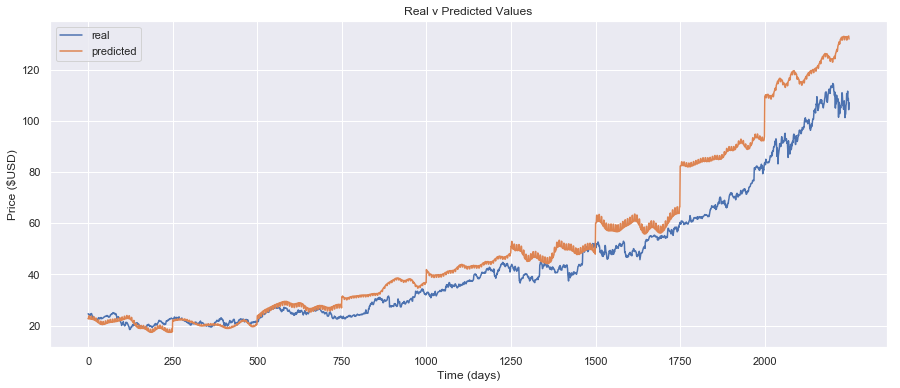

In [57]:
# plot real versus predicted values 
plt.figure(figsize=(15,6))
plt.plot(results_p_comp['real'], label='real')
plt.plot(results_p_comp['predicted'], label='predicted')
plt.legend()
plt.xticks(np.arange(0,2250,250))  # set x-ticks to 250 to match with training/testing partitions
plt.title('Real v Predicted Values')
plt.ylabel('Price ($USD)')
plt.xlabel('Time (days)')
plt.show()

In [58]:
correct_direction = []
for i in np.arange(0, len(results_p_comp)-250, 250):
    if (results_p_comp.predicted.iloc[i+250]>=results_p_comp.predicted.iloc[i] and results_p_comp.real.iloc[i+250]>=results_p_comp.real.iloc[i] or results_p_comp.predicted.iloc[i+250]<=results_p_comp.predicted.iloc[i] and results_p_comp.real.iloc[i+250]<=results_p_comp.real.iloc[i]):
        correct_direction.append(1)
    else:
        correct_direction.append(0)

In [59]:
print('the model correctly predicted the yearly direction of the stock movement {}% of the time'.format(np.mean(correct_direction)*100))

the model correctly predicted the yearly direction of the stock movement 87.5% of the time


In [60]:
print('the model correctly predicted the yearly direction of the stock movement {} out of {} times'.format(sum(correct_direction), len(correct_direction)))

the model correctly predicted the yearly direction of the stock movement 7 out of 8 times


## further testing

In [79]:
def train_prophet(df, start, increment):
    p_train = df_p.iloc[start:start+increment]
    m = Prophet(yearly_seasonality=True)
    m.fit(p_train)
    future = m.make_future_dataframe(increment)
    forecast = m.predict(future)
    return forecast.iloc[-increment:, -1]

In [71]:
def plot_prophet(real, pred, real_start, increment):
    p_real = real.iloc[real_start:real_start+increment, 1]
    p_real.reset_index(inplace=True, drop=True)

    p_pred = pred.iloc[-increment:, -1]
    p_pred.reset_index(inplace=True, drop=True)

    plt.figure(figsize=(15,6))
    plt.plot(p_real, label='real')
    plt.plot(p_pred, label='predicted')
    plt.legend()
    plt.title('Real v Predicted Values')
    plt.ylabel('Price ($USD)')
    plt.xlabel('Time (days)')
    plt.show()

In [80]:
p_2011 = train_prophet(df_p, 0, 250)
p_2012 = train_prophet(df_p, 250, 250)
p_2013 = train_prophet(df_p, 500, 250)
p_2014 = train_prophet(df_p, 750, 250)
p_2015 = train_prophet(df_p, 1000, 250)
p_2016 = train_prophet(df_p, 1250, 250)
p_2017 = train_prophet(df_p, 1500, 250)
p_2018 = train_prophet(df_p, 1750, 250)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,250,251,252,253,254,255,256,257,258,259,...,490,491,492,493,494,495,496,497,498,499
yhat,22.757965,22.652884,23.819904,23.803017,22.657289,22.644334,22.637533,22.641855,22.537590,23.703935,...,18.522581,18.523126,17.401181,17.418139,17.447243,17.493394,17.436872,18.656907,18.696712,17.610681
yhat,22.227642,22.267403,21.801336,21.944846,21.923952,21.974958,21.931388,22.477144,22.506722,22.030100,...,19.634545,19.794533,19.803800,19.897233,19.906735,20.514423,20.612892,20.210136,20.419676,20.465638
yhat,23.813188,23.855257,24.014962,24.161424,22.839780,22.945763,24.400071,24.521074,24.589833,24.772688,...,28.310482,28.364443,26.943038,26.943221,28.287009,28.294158,28.247143,28.313704,28.363909,26.943831
yhat,31.191543,31.039770,31.580038,31.387241,31.332480,31.176191,31.116501,30.325766,30.250843,30.875482,...,36.561445,36.588091,36.729446,36.743387,36.826148,36.148881,36.157948,36.837301,36.760980,36.799780
yhat,41.914671,40.765457,40.604004,41.291039,41.170227,41.004384,40.897763,40.807230,39.675114,39.542014,...,46.532677,47.489970,47.641405,47.746591,47.906674,48.075596,47.193024,47.297227,48.246506,48.382257
yhat,50.981596,50.870847,52.915253,52.744128,50.352266,50.067826,49.928227,49.855772,49.790233,51.899560,...,51.736814,51.611792,49.247487,48.969501,48.813325,48.700059,48.569049,50.588643,50.386738,47.957060
yhat,60.085952,60.181104,60.264659,63.065852,63.192633,60.641293,60.808146,60.944390,60.895323,60.822774,...,63.703102,66.393659,66.421928,63.786832,63.887014,63.975645,63.899600,63.821857,66.474761,66.469124
yhat,82.345362,82.359749,82.347124,82.667325,83.988361,84.020537,82.641170,82.653577,82.585103,82.489557,...,92.160321,92.381050,93.634073,93.630632,92.248149,92.289255,92.279860,92.271659,92.623868,94.003243


In [85]:
agg_results = pd.DataFrame([p_2011, p_2012, p_2013, p_2014, p_2015, p_2016, p_2017, p_2018]).T.melt()

In [102]:
df_p_real_new = df.iloc[250:2250, 5]
type(df_p_real_new)

pandas.core.series.Series

In [93]:
pd.DataFrame(results_p).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Columns: 250 entries, 0 to 249
dtypes: float64(250)
memory usage: 17.7 KB


In [105]:
results_comp = agg_results.merge(df_p_real_new, on=agg_results.index).drop(['variable', 'key_0'], axis=1)

In [107]:
results_comp.rename({'value': 'predicted', '5. adjusted close': 'real'}, axis=1, inplace=True)

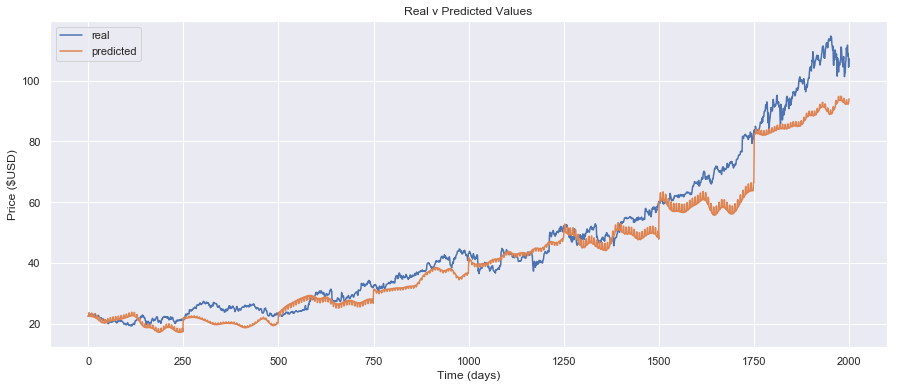

In [108]:
# plot real versus predicted values 
plt.figure(figsize=(15,6))
plt.plot(results_comp['real'], label='real')
plt.plot(results_comp['predicted'], label='predicted')
plt.legend()
plt.xticks(np.arange(0,2250,250))  # set x-ticks to 250 to match with training/testing partitions
plt.title('Real v Predicted Values')
plt.ylabel('Price ($USD)')
plt.xlabel('Time (days)')
plt.show()

In [24]:
p_train = df_p.iloc[1500:1750]
m = Prophet(yearly_seasonality=True)
m.fit(p_train)
future = m.make_future_dataframe(250)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


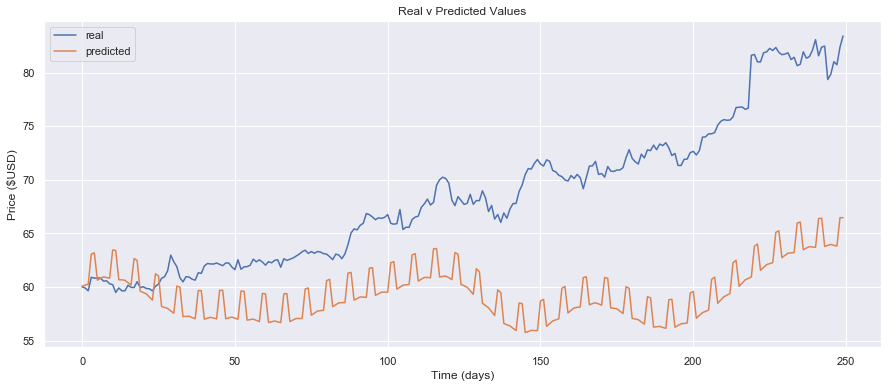

In [50]:
p_real = df_p.iloc[1750:2000, 1]
p_real.reset_index(inplace=True, drop=True)

p_pred = forecast.iloc[-250:, -1]
p_pred.reset_index(inplace=True, drop=True)

plt.figure(figsize=(15,6))
plt.plot(p_real, label='real')
plt.plot(p_pred, label='predicted')
plt.legend()
#plt.xticks(np.arange(0,2250,250))  # set x-ticks to 250 to match with training/testing partitions
plt.title('Real v Predicted Values')
plt.ylabel('Price ($USD)')
plt.xlabel('Time (days)')
plt.show()